# De-Novo molecule gen

This Python notebook creates an AI autoencoder model for learning how to recreate SMILES molecules. The autoencoder is developed using Long Short Term Memory (LSTM) cells.

Autoencoder model architecture refrence: https://www.cheminformania.com/master-your-molecule-generator-seq2seq-rnn-models-with-smiles-in-keras/

Author: Harshkumar patel(x2020fle@stfx.ca), Milan Mangukiya(x2020flg@stfx.ca)

In [ ]:
# core libraries 
import sys
import os
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
import tensorflow as tf
print("Current TensorFlow version:", tf.__version__)

# Keras libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import Sequence

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Current TensorFlow version: 2.9.2


In [ ]:
# enable the GPU processing in colab
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Please select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Found GPU at: /device:GPU:0
Wed Dec 14 17:46:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    50W / 400W |    632MiB / 40536MiB |      4%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                            

In [ ]:
# fixing random seed
seed = 700
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Google Drive Mounting
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
# data load functions for .smi and .json
def load_smi(data):
    with open(data, 'r') as f:
        smiles = [s.rstrip() for s in f]
    return np.array(smiles)

def load_dict(input_dict):
    with open(input_dict, 'r') as fd:
        out_dict = json.load(fd)
    return out_dict  

In [ ]:
# loading datasets & spliting to traning and testing sets
# Note: make sure "next_gen_data" folder exist in google drive having smiles data
smi_data = '/drive/My Drive/next_gen_data/moses.smi'
data = load_smi(smi_data)
entire_train, test = train_test_split(data, test_size=0.2, random_state=seed)
print("Training set shape:", entire_train.shape)
print("Testing set shape:", test.shape)
print("Sample training smile: \n", entire_train[0])


# store test set for smile generation
np.save('/drive/My Drive/next_gen_data/test.npy', test)
print('Test file stored to google drive')


# validation set for training autoencoder 
train, val_set = train_test_split(entire_train, test_size= 0.10, random_state=seed)
print("Validation set shape:", val_set.shape)

Training set shape: (1267730,)
Testing set shape: (316933,)
Sample training smile: 
 COCCOc1cccc(NC(=O)Cc2ccccc2)c1
Test file stored to google drive
Validation set shape: (126773,)


In [ ]:
# mapping smiles to index and index to smiles back using mapping dict
c2i_dict = '/drive/My Drive/next_gen_data/char_to_int.json'
i2c_dict = '/drive/My Drive/next_gen_data/int_to_char.json'
smi2index = load_dict(c2i_dict)
index2smi = load_dict(i2c_dict)
n_feature = len(smi2index)
print("Feature/char set length:", n_feature)
print("Dict map characters to integers:\n", smi2index)
print("Dict map integers to characters:\n", index2smi)

Feature/char set length: 45
Dict map characters to integers:
 {'n': 0, '[': 1, '\\': 2, 'E': 3, 'H': 4, ')': 5, 'B': 6, '9': 7, '2': 8, ']': 9, '7': 10, '!': 11, 't': 12, 's': 13, 'o': 14, 'c': 15, 'K': 16, '-': 17, '/': 18, 'l': 19, 'A': 20, 'r': 21, '@': 22, 'C': 23, '=': 24, '6': 25, 'N': 26, 'L': 27, 'a': 28, '5': 29, 'S': 30, 'T': 31, '#': 32, '+': 33, 'P': 34, 'i': 35, '(': 36, '8': 37, '1': 38, 'I': 39, 'e': 40, 'O': 41, '3': 42, 'F': 43, '4': 44}
Dict map integers to characters:
 {'0': 'n', '1': '[', '2': '\\', '3': 'E', '4': 'H', '5': ')', '6': 'B', '7': '9', '8': '2', '9': ']', '10': '7', '11': '!', '12': 't', '13': 's', '14': 'o', '15': 'c', '16': 'K', '17': '-', '18': '/', '19': 'l', '20': 'A', '21': 'r', '22': '@', '23': 'C', '24': '=', '25': '6', '26': 'N', '27': 'L', '28': 'a', '29': '5', '30': 'S', '31': 'T', '32': '#', '33': '+', '34': 'P', '35': 'i', '36': '(', '37': '8', '38': '1', '39': 'I', '40': 'e', '41': 'O', '42': '3', '43': 'F', '44': '4'}


In [ ]:
# add the beginning and ending character markers for running autoencoder in batch mode
# add fillers for constant sequence length of 100, and turn the seq2seq of one-hot vectors

def vectorize(smiles, padding_len, n_feature):
    one_hot = np.zeros((smiles.shape[0], padding_len, n_feature), dtype=np.int8)
    for i, smile in enumerate(smiles):
        # encoding smiles with '!' as staring symbol
        one_hot[i,0,smi2index["!"]] = 1
        # one hot encode the smiles characters
        for j, c in enumerate(smile):
            one_hot[i,j+1,smi2index[c]] = 1
        # encoding smiles with 'E' as ending symbol
        one_hot[i,len(smile)+1:,smi2index["E"]] = 1
    # return two set, one for the input and one for the output
    return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [ ]:
# Vectorize train, test and validation set
# np.set_printoptions(threshold=sys.maxsize)

padding = 101
X_train, y_train = vectorize(train, padding, n_feature)

X_val, y_val = vectorize(val_set, padding, n_feature)
X_test, y_test = vectorize(test, padding, n_feature)
print("Train input shape:", X_train.shape)
print("Train output shape:", y_train.shape)
print("Val input shape:", X_val.shape)
print("Val output shape:", y_val.shape)
print("Test input shape:", X_test.shape)
print("Test output shape:", y_test.shape)

Train input shape: (1140957, 100, 45)
Train output shape: (1140957, 100, 45)
Val input shape: (126773, 100, 45)
Val output shape: (126773, 100, 45)
Test input shape: (316933, 100, 45)
Test output shape: (316933, 100, 45)


In [ ]:
# map back to 2 smiles for observation.
x="".join([index2smi[str(idx)] for idx in np.argmax(X_train[0,:,:], axis=1)])
y="".join([index2smi[str(idx)] for idx in np.argmax(y_train[0,:,:], axis=1)])
print(x)
print(y)

!Cc1ccc(S(=O)(=O)NCCc2cn3ccccc3n2)c(C)c1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
Cc1ccc(S(=O)(=O)NCCc2cn3ccccc3n2)c(C)c1EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE


In [ ]:
# LSTM autoencoder model
def lstm_autoecoder_model(X, y):
    # encoder layers
    encoder_input = Input(shape=(X.shape[1:]))
    _, state_h, state_c = LSTM(256, return_state=True)(encoder_input)
    states = Concatenate(axis=-1)([state_h, state_c])
    neck = Dense(128, activation='relu')(states)

    # decoder layers
    state_h_decoded = Dense(256, activation='relu')(neck)
    state_c_decoded = Dense(256, activation='relu')(neck)
    encoder_states = [state_h_decoded, state_c_decoded]
    decoder_input = Input(shape=(X.shape[1:]))
    decoder_lstm = LSTM(256, return_sequences=True)(decoder_input, initial_state=encoder_states)
    decoder_output = Dense(y.shape[2], activation='softmax')(decoder_lstm)
    
    model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)   
    return model 

In [ ]:
# model make
model = lstm_autoecoder_model(X_train, y_train)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 45)]    0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        309248      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                                  
 concatenate (Concatenate)      (None, 512)          0           ['lstm[0][1]',                   
                                                                  'lstm[0][2]']               

In [ ]:
# model compile
batch = 256
#steps_by_epoch = int(len(X_train) / batch)
#print("steps per epoch: ",steps_by_epoch)
initial_learning_rate = 0.01
decay_steps = 1
decay_rate = 0.5

#learning_rate_fn  = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate, 
#                                                                   decay_steps=decay_steps, 
#                                                                   decay_rate=decay_rate, 
#                                                                   staircase=False)

#opt=Adam(learning_rate = 0.005, beta_1 = 0.9, beta_2 = 0.999, decay=0.05)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# data sequence generator to batch feed the data
class DataGenerator(Sequence):
    def __init__(self, input_data, labels, batch_size):
        self.input_data, self.labels = input_data, labels
        self.batch_size = batch_size
    
    def __len__(self):
        return int(np.ceil(len(self.input_data) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        x = self.input_data[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_x, batch_y = np.array(x), np.array(y)
        
        return [batch_x, batch_x], batch_y

In [ ]:
#  callbacks
file="/drive/My Drive/next_gen_data/LSTM_Chem_weights-{epoch:02d}-{acc:.4f}-{val_loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(file, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
tb = TensorBoard(log_dir="/drive/My Drive/next_gen_data/logs/", histogram_freq=1, write_graph=True, write_images=True)

In [ ]:
# fit the model
epochs = 65
train_gen = DataGenerator(X_train, y_train, batch)
val_gen = DataGenerator(X_val, y_val, batch)
val_steps = int(len(X_val) / batch)

fit_history = model.fit(train_gen,                          
                        epochs=epochs, 
                        verbose=1, 
                        validation_data=val_gen, 
                        validation_steps=val_steps, 
                        use_multiprocessing=False, 
                        shuffle=True, 
                        callbacks=[])

Epoch 1/65
4457/4457 [==============================] - 91s 19ms/step - loss: 0.3293 - acc: 0.8916 - val_loss: 0.2258 - val_acc: 0.9196
Epoch 2/65
4457/4457 [==============================] - 87s 19ms/step - loss: 0.1998 - acc: 0.9282 - val_loss: 0.1731 - val_acc: 0.9370
Epoch 3/65
4457/4457 [==============================] - 87s 20ms/step - loss: 0.1428 - acc: 0.9484 - val_loss: 0.1193 - val_acc: 0.9568
Epoch 4/65
4457/4457 [==============================] - 87s 19ms/step - loss: 0.1058 - acc: 0.9618 - val_loss: 0.0915 - val_acc: 0.9672
Epoch 5/65
4457/4457 [==============================] - 87s 20ms/step - loss: 0.0829 - acc: 0.9701 - val_loss: 0.0721 - val_acc: 0.9742
Epoch 6/65
4457/4457 [==============================] - 87s 20ms/step - loss: 0.0636 - acc: 0.9772 - val_loss: 0.0559 - val_acc: 0.9801
Epoch 7/65
4457/4457 [==============================] - 87s 19ms/step - loss: 0.0441 - acc: 0.9846 - val_loss: 0.0376 - val_acc: 0.9869
Epoch 8/65
4457/4457 [==========================

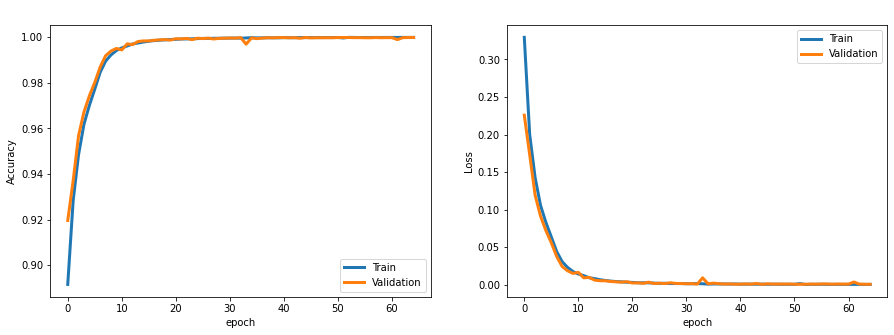

In [ ]:
# plot the autoencoder loss and accuracy
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# history for accuracy
axis1.plot(fit_history.history["acc"], label='Train', linewidth=3)
axis1.plot(fit_history.history["val_acc"], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=15, color="white")
axis1.set_ylabel('Accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='lower right')

# history for loss
axis2.plot(fit_history.history["loss"], label='Train', linewidth=3)
axis2.plot(fit_history.history["val_loss"], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=15, color="white")
axis2.set_ylabel('Loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [ ]:
# get the test score
score, acc = model.evaluate([X_test, X_test], y_test, batch_size=batch, verbose=0)
print(f'Test accuracy: {acc}')

Test accuracy: 0.9998427033424377


In [ ]:
# save our base model & weights
mod_file = '/drive/My Drive/next_gen_data/LSTM_model.h5'
model.save(mod_file)
print("Model stored in google drive")

Model stored in google drive
